In [1]:
from HeaderP import *

In [2]:
import Astraea

In [3]:
def readsimdata(simNo,z,Rcut,select,Rcut_thread,zcut_thread):
    if simNo=='data':
        data=pd.read_pickle('../SecondYear/CannonDR16_cut.pkl')
        data['z_today']=data['z']
        data['x_today']=data['X']
        data['y_today']=data['Y']
        data['feh_scale']=data['M_H']
        data['ofe_scale']=data['O_FE']
        data['age']=data['Age']
    elif select:
        data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'_apogee_selec.pkl')
        data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
        data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
        scale_fe=0.250019907951355/0.35828184923028494
        scale_o=0.10861970484256744/0.09543676896214373
        data['feh_scale']=data['feh']*scale_fe-0.0906638577580452+0.08980628554112494
        data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-0.17121922547292423
        data['dR']=data['R']-data['R_bir']
        data['dz']=abs(data['z_today'])-abs(data['z_birth'])
    
    elif not select:
        if z=='0':
            data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'.pkl')
        else:
            data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'_z'+z+'.pkl')
            try:
                data['x_today']=data['x']
                data['y_today']=data['y']
                data['z_today']=data['z']
            except:
                print(np.shape(data['x_today']))

        data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
        data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
        scale_fe=0.250019907951355/0.35828184923028494
        scale_o=0.10861970484256744/0.09543676896214373
        data['feh_scale']=data['feh']*scale_fe-0.0906638577580452+0.08980628554112494
        data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-0.17121922547292423
        
        if Rcut:
            data=data.loc[data['R_bir']<Rcut_thread].reset_index(drop=True)
            data=data.loc[abs(data['z_birth'])<zcut_thread].reset_index(drop=True)
        data['dR']=data['R']-data['R_bir']
        data['dz']=abs(data['z_today'])-abs(data['z_birth'])
    return data

def normalize_data(data):
    return (data-np.mean(data))/np.std(data)

# load simulation

In [4]:
simNo='2_79e12'
z='0'
Rcut=True
select=False
Rcut_thread=30
zcut_thread=5


data=readsimdata(simNo,z,Rcut,select,Rcut_thread,zcut_thread)
data_sr=data.loc[abs(data['R']-8.2)<0.2].reset_index(drop=True)
print(np.shape(data_sr))

(81646, 34)


# Eq 1

In [5]:
def train(y, X):
    """
    
    Args:
        y (array): An Nstar array of rotation periods.
        X (array): An Nstar x NX array of features.
        
    Returns:
        weights (array): The array of weights of length NX + 1.
        
    """
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)  # Shape: Nstars x Nfeatures (incl crossterms)
    AT = A.T
    ATA = np.dot(AT, A)
    
    weights = np.linalg.solve(ATA, np.dot(AT, y))
    return weights

In [125]:
from itertools import combinations_with_replacement

In [126]:
args = normalize_data(data_sr['feh_scale']), normalize_data(data_sr['R']), normalize_data(data_sr['age'])
args_name = '$θ_{[Fe/H]}$', '$θ_τ$'
X = list(args)
X_names = list(args_name)
for a, b in combinations_with_replacement(args, 2):
    X.append(a * b)

for a, b in combinations_with_replacement(args_name, 2):
    if a==b=='$θ_{[Fe/H]}$':
        X_names.append('$θ_{[Fe/H]^2}$')
    elif a==b=='$θ_R$':
        X_names.append('$θ_{R^2}$')
    elif a==b=='$θ_τ$':
        X_names.append('$θ_{τ^2}$')
    else:
        X_names.append(str(a + '*' + b))
        
X = np.array(X).T
print(np.shape(X), np.shape(X_names), len(args))

(81646, 9) (5,) 3


In [127]:
# Define the number of training and validating stars.
Ntrain = int(0.8*np.shape(X)[0])
y = data_sr['R_bir'].values

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]

In [128]:
weights = train(y_train, X_train)
weights

array([ 9.97180864e+00, -4.23788432e+00,  1.75743053e-02, -4.02022551e+00,
        1.32892094e-01, -5.58685613e-03,  1.87251939e+00, -1.56818027e-02,
       -7.52065266e-03, -1.94257242e+00])

(-10.0, 15.0)

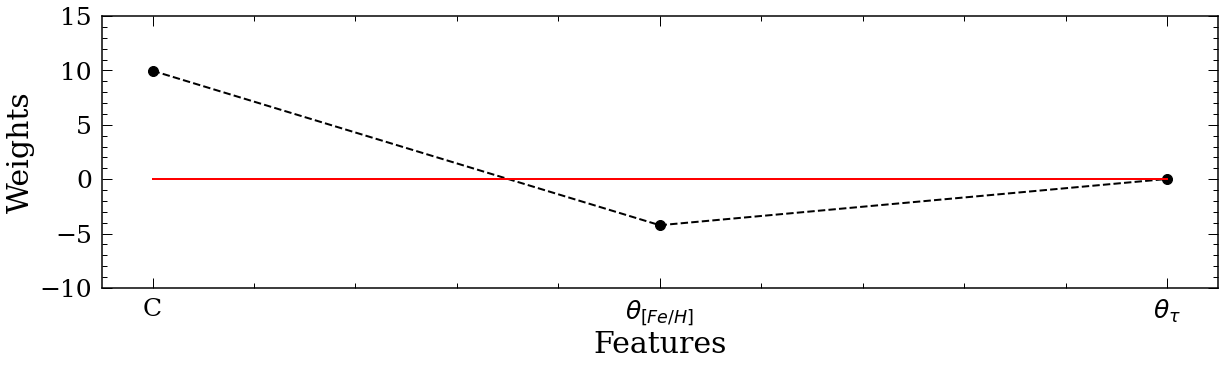

In [129]:
plt.figure(figsize=(20,5))
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)], weights[:(len(args_name)+1)], 'k--o', markersize=10)
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)],np.zeros(len(np.append(['C'],X_names)))[:(len(args_name)+1)],'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-10,15])

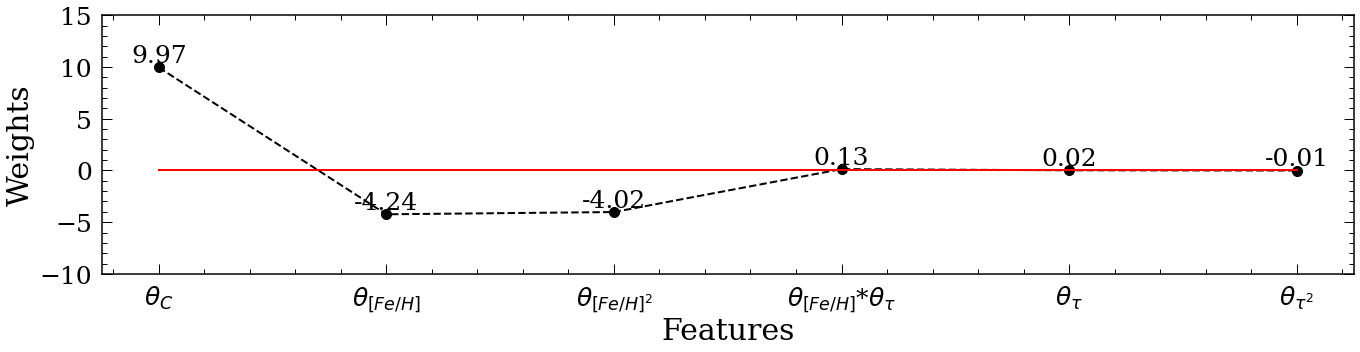

In [130]:
plt.figure(figsize=(19,5))
allnames = np.append(['$θ_C$'],X_names)
absweights, weights_imp, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, allnames)))
weights_imp, allnames = weights_imp[::-1], allnames[::-1]
plt.plot(allnames, weights_imp, 'k--o', markersize=10)
plt.plot(allnames,np.zeros(len(np.append(['C'],X_names))),'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-10,15])

for i, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (allnames[i], weights_imp[i]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig('importance.png')

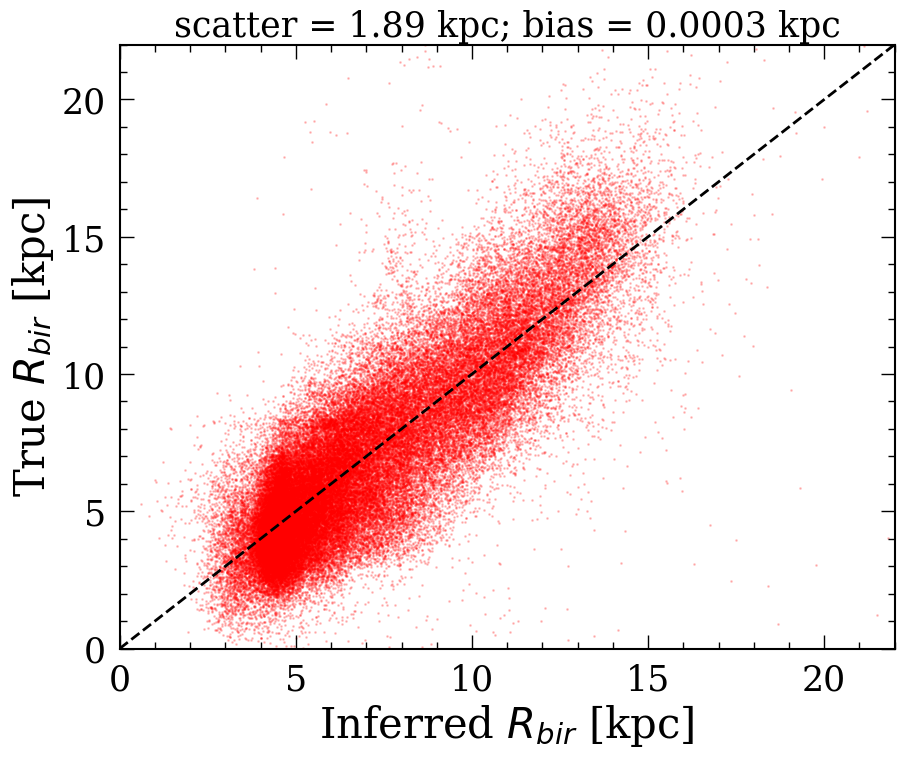

In [131]:
A = np.concatenate((np.ones((len(X), 1)), X), axis=1)
y_predict = np.dot(weights.T, A.T)

xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y-y_predict)
bias  = np.mean(y-y_predict)

plt.scatter(y_predict.T, y, s=1, c='r', alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.xlabel("Inferred $R_{bir}$ [kpc]")
plt.ylabel("True $R_{bir}$ [kpc]")
plt.title('scatter = %.2f kpc; bias = %.4f kpc'%(scatter, bias),fontsize=25)
plt.savefig('Rbirth.png')

# Minchev2018

In [75]:
tau0 = 14.1
R0 = 8.2
def minchev(feh, tau, Cb, Cm, a, b):
    return (feh-Cb)/(a*np.log(1-tau/tau0)+Cm)-b/(a+Cm/np.log(1-tau/tau0))+R0



In [77]:
import emcee
import corner


def get_chisq(para, feh, age, rbir):
    Cb, Cm, a, b = para
    # put stars back into their birth raii
    rbirth_inf = minchev(feh, age, Cb, Cm, a, b)
    
    return sum((rbirth_inf-rbir)**2)


def log_marg_prob_scatter(params, feh, age, rbir):
    Cb, Cm, a, b = params
    
    if not -1.5 < Cb < -0.5:
        return -np.inf
    
    if not -0.5 < Cm < 0:
        return -np.inf
    
    if not 0 < a < 0.5:
        return -np.inf
    
    if not 0.5 < b < 1.5:
        return -np.inf

    # Compute the log likelihood up to a constant.
    ll = -0.5 * get_chisq(params, feh, age, rbir)
    return ll 

# run MCMC
nwalkers = 1000
feh_sample, ages_sample, rbirths = data_sr['feh'].values, data_sr['age'].values, data_sr['R_bir'].values

sampler_scatter = emcee.EnsembleSampler(nwalkers, 4, log_marg_prob_scatter, args=(feh_sample, ages_sample, rbirths))
p0 = np.array([-1, -0.05, 0.05, 0.6])
p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
pos, _, _ = sampler_scatter.run_mcmc(p0, 100, progress=True)


100%|██████████| 100/100 [11:03<00:00,  6.63s/it]


In [69]:
sampler_scatter.reset()
sampler_scatter.run_mcmc(pos, 500, progress=True, store=True);


100%|██████████| 500/500 [49:00<00:00,  5.88s/it]


In [78]:
flat_samples = sampler_scatter.flatchain


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

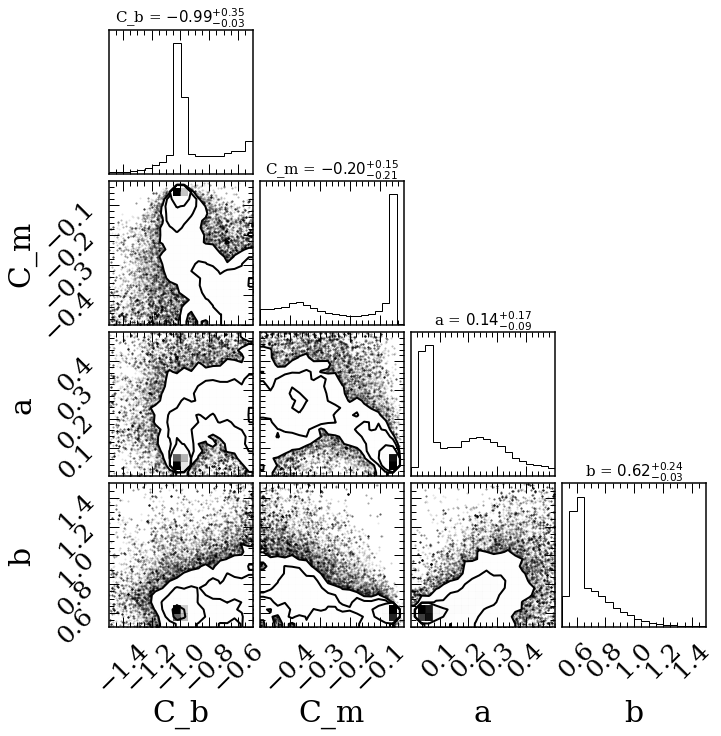

In [79]:
corner.corner(flat_samples, labels=['C_b', 'C_m', 'a', 'b'],show_titles=True, title_kwargs={"fontsize": 15},
             labelpad=0.2);

from IPython.display import display, Math
labels = ['C_b', 'C_m', 'a', 'b']
para_final = np.zeros(4)
for i in range(4):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    para_final[i] = mcmc[1]
    display(Math(txt))

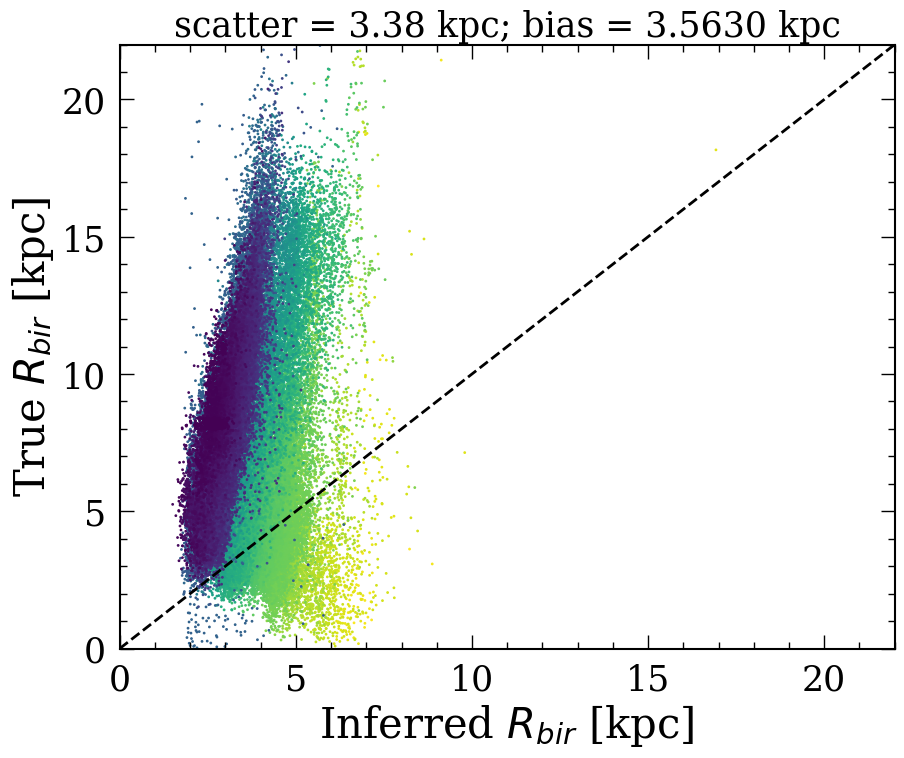

In [80]:
Cb, Cm, a, b = para_final
y_predict = minchev(feh_sample, ages_sample, Cb, Cm, a, b)
y_test = data_sr['R_bir'].values

xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_predict.T, y_test, s=1, c=data_sr['age'])
plt.plot(xs, xs, "k--")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.xlabel("Inferred $R_{bir}$ [kpc]")
plt.ylabel("True $R_{bir}$ [kpc]")
plt.title('scatter = %.2f kpc; bias = %.4f kpc'%(scatter, bias),fontsize=25)
plt.savefig('Rbirth.png')

# Frankle2018

In [62]:
tau0 = 12
R0 = 8.2
def frankle(feh, tau, Cb, Cm, Fm, gamma):
    #print(Cb, Cm, Fm, gamma)
    return feh/Cm-Fm/Cm+(Fm/Cm+R0-Cb/Cm)*(1-tau/tau0)**gamma

In [63]:
import emcee
import corner


def get_chisq(para, feh, age, rbir):
    Cb, Cm, Fm, gamma = para
    # put stars back into their birth raii
    rbirth_inf = frankle(feh, age, Cb, Cm, Fm, gamma)
    
    return sum((rbirth_inf-rbir)**2)


def log_marg_prob_scatter(params, feh, age, rbir):
    Cb, Cm, Fm, gamma = params
    
    if not 0 < Cb < 0.5:
        return -np.inf
    
    if not -0.5 < Cm < 0:
        return -np.inf
    
    if not -5 < Fm < 0:
        return -np.inf
    
    if not 0 < gamma < 0.5:
        return -np.inf

    # Compute the log likelihood up to a constant.
    ll = -0.5 * get_chisq(params, feh, age, rbir)
    return ll 

# run MCMC
nwalkers = 256
data_sr_f = data_sr.loc[data_sr['age']<12]
feh_sample, ages_sample, rbirths = data_sr_f['feh'].values, data_sr_f['age'].values, data_sr_f['R_bir'].values

sampler_scatter = emcee.EnsembleSampler(nwalkers, 4, log_marg_prob_scatter, args=(feh_sample, ages_sample, rbirths))
p0 = np.array([0.1, -0.1, -0.05, 0.5])
p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
pos, _, _ = sampler_scatter.run_mcmc(p0, 100, progress=True)

  0%|          | 0/100 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100/100 [02:50<00:00,  1.71s/it]


In [64]:
sampler_scatter.reset()
sampler_scatter.run_mcmc(pos, 1000, progress=True, store=True);



100%|██████████| 5000/5000 [2:28:54<00:00,  1.79s/it]  


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

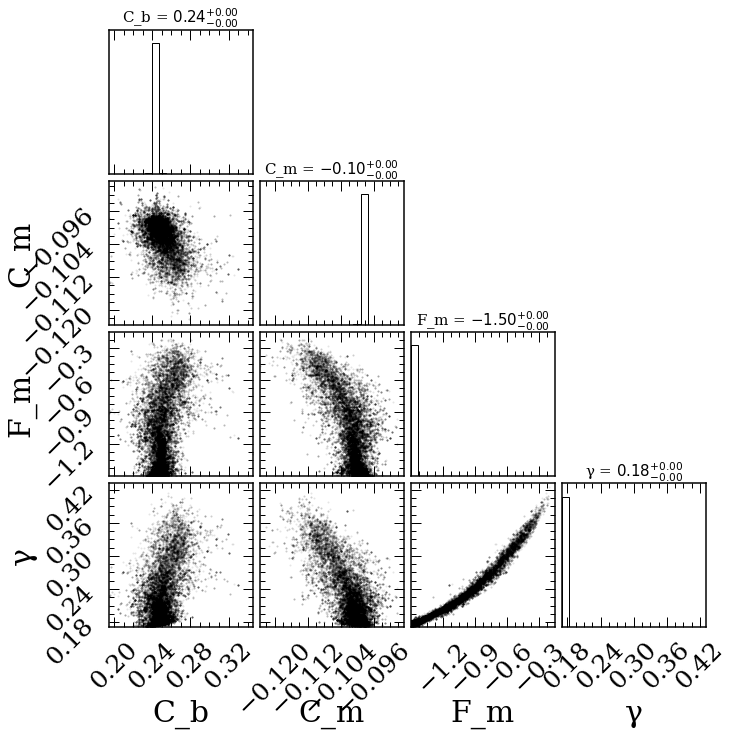

In [65]:
flat_samples = sampler_scatter.flatchain

corner.corner(flat_samples, labels=['C_b', 'C_m', 'F_m', 'γ'],show_titles=True, title_kwargs={"fontsize": 15},
             labelpad=0.2);

from IPython.display import display, Math
para_final_fran=np.zeros(4)
labels = ['C_b', 'C_m', 'F_m', 'γ']
for i in range(4):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    para_final_fran[i] = mcmc[1]
    display(Math(txt))

In [73]:
Cb, Cm, Fm, gamma= para_final_fran
y_predict = frankle(feh_sample, ages_sample, Cb, Cm, Fm, gamma)
y_test = data_sr_f['R_bir'].values

xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_predict.T, y_test, s=1, c=data_sr_f['age'])
plt.plot(xs, xs, "k--")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.xlabel("Inferred $R_{bir}$ [kpc]")
plt.ylabel("True $R_{bir}$ [kpc]")
plt.title('scatter = %.2f kpc; bias = %.4f kpc'%(scatter, bias),fontsize=25)
#plt.savefig('Rbirth.png')

ValueError: operands could not be broadcast together with shapes (80562,) (81646,) 

<Figure size 1000x800 with 0 Axes>